In [20]:
import numpy as np
import pandas as pd
from scipy.stats import norm, multivariate_normal

# Set random seed for reproducibility
np.random.seed(42)

def simulate_scm1(n, rho):
    """
    SCM 1: Correlated noise via Gaussian copula
      Y1 = X + U1
      Y2 = X + U2
    where (U1, U2) ~ Gaussian copula with correlation rho
    """
    # 1. Sample X ~ Bernoulli(0.5)
    X = np.random.binomial(1, 0.5, size=n)
    
    # 2. Generate correlated normals (Z1, Z2) with Corr(Z1,Z2)=rho
    mean = [0, 0]
    cov = [[1, rho], [rho, 1]]
    z = multivariate_normal.rvs(mean=mean, cov=cov, size=n)
    
    # 3. Convert to uniforms: U1 = Φ(Z1), U2 = Φ(Z2)
    U1 = norm.cdf(z[:, 0])
    U2 = norm.cdf(z[:, 1])
    
    # 4. Structural equations
    Y1 = X + U1
    Y2 = X + U2
    
    return X, U1, U2, Y1, Y2

def simulate_scm2(n, rho):
    """
    SCM 2: Independent uniforms, but impose Gaussian‐copula condition in f2
      Y1 = X + U1
      Y2 = X + Φ( ρ·Φ^{-1}(Y1 - X) + √(1-ρ²)·Φ^{-1}(U2) )
    """
    # 1. Sample X ~ Bernoulli(0.5)
    X = np.random.binomial(1, 0.5, size=n)
    
    # 2. Draw independent uniforms
    U1 = np.random.uniform(0, 1, size=n)
    U2 = np.random.uniform(0, 1, size=n)
    
    # 3. Y1 = X + U1
    Y1 = X + U1
    
    # 4. Recover latent normals for conditional quantile
    z1 = norm.ppf(Y1 - X)   # = Φ⁻¹(U1)
    z2 = norm.ppf(U2)
    
    # 5. Compose conditional quantile: Z2_cond = ρ·z1 + sqrt(1-ρ²)·z2
    z2_cond = rho*z1 + np.sqrt(1 - rho**2)*z2
    U2_cond = norm.cdf(z2_cond)
    
    # 6. Y2 = X + U2_cond
    Y2 = X + U2_cond
    
    return X, U1, U2, Y1, Y2

# Parameters
n_samples = 5000
rho = 0.9

# Simulate both SCMs
X1, U1_s1, U2_s1, Y1_s1, Y2_s1 = simulate_scm1(n_samples, rho)
X2, U1_s2, U2_s2, Y1_s2, Y2_s2 = simulate_scm2(n_samples, rho)

# Compile results into a DataFrame
df = pd.DataFrame({
    'X_scm1': X1,
    'U1_scm1': U1_s1,
    'U2_scm1': U2_s1,
    'Y1_scm1': Y1_s1,
    'Y2_scm1': Y2_s1,
    'X_scm2': X2,
    'U1_scm2': U1_s2,
    'U2_scm2': U2_s2,
    'Y1_scm2': Y1_s2,
    'Y2_scm2': Y2_s2
})

print(df.head())

   X_scm1   U1_scm1   U2_scm1   Y1_scm1   Y2_scm1  X_scm2   U1_scm2   U2_scm2  \
0       0  0.867863  0.518891  0.867863  0.518891       0  0.209163  0.370601   
1       1  0.578291  0.727757  1.578291  1.727757       1  0.311888  0.194964   
2       1  0.267707  0.334227  1.267707  1.334227       0  0.116408  0.934781   
3       1  0.711886  0.494775  1.711886  1.494775       1  0.456899  0.581344   
4       0  0.376117  0.245475  0.376117  0.245475       0  0.984309  0.287325   

    Y1_scm2   Y2_scm2  
0  0.209163  0.191508  
1  1.311888  1.207190  
2  0.116408  0.339219  
3  1.456899  1.496840  
4  0.984309  0.954711  


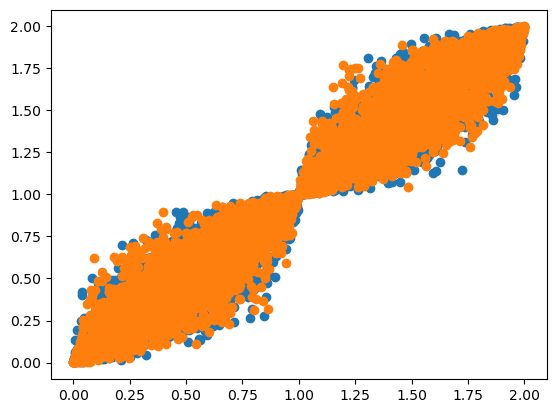

In [21]:
import matplotlib.pyplot as plt
plt.scatter(Y1_s1,Y2_s1)
plt.scatter(Y1_s2,Y2_s2)

In [32]:
def scm1_map_from_0_to_1(Y1, Y2):
    """
    SCM1 map: for a point observed under X=0 (so Y1=U1, Y2=U2),
    transport to X=1 by adding 1 to each:
      Y1(1) = 1 + U1 = 1 + Y1,
      Y2(1) = 1 + U2 = 1 + Y2.
    """
    Y1_new = 1 + Y1
    Y2_new = 1 + Y2
    return Y1_new, Y2_new

def scm2_map_from_0_to_1(Y1, Y2, rho):
    """
    SCM2 map: for a point observed under X=0 (so Y1=U1, Y2=U2_cond),
    recover U1, U2, then replay under X=1:
      U1 = Y1
      z1 = Φ^{-1}(U1)
      z2_cond = Φ^{-1}(U2_cond = Y2)
      z2 = (z2_cond - rho*z1) / sqrt(1 - rho^2)   => U2 = Φ(z2)
      Then new U2_cond1 = Φ(rho*z1 + sqrt(1 - rho^2)*Φ^{-1}(U2))
      Y1(1) = 1 + U1
      Y2(1) = 1 + U2_cond1
    """
    # Step 1: Recover U1 and U2_cond from the Y-values under X=0
    U1 = Y1                 # since Y1 = 0 + U1
    U2_cond = Y2            # since Y2 = 0 + U2_cond

    # Step 2: Compute z1, z2_cond (both in ℝ)
    z1 = norm.ppf(U1)       # safe because U1 in (0,1)
    z2_cond = norm.ppf(U2_cond)  # safe because U2_cond in (0,1)

    # Step 3: Recover the latent U2
    z2 = (z2_cond - rho * z1) / np.sqrt(1 - rho**2)
    U2 = norm.cdf(z2)       # now U2 in (0,1)

    # Step 4: Build the new conditional U2 under X=1
    z2_cond1 = rho * z1 + np.sqrt(1 - rho**2) * norm.ppf(U2)
    U2_cond1 = norm.cdf(z2_cond1)

    # Step 5: Transport to X=1
    Y1_new = 1 + U1
    Y2_new = 1 + U2_cond1

    return Y1_new, Y2_new

rho = 0.5

# Simulate data from SCM1
X, U1, U2, Y1, Y2 = simulate_scm1(n_samples, rho)

# Filter for X=0
mask = (X == 0)
Y1_x0 = Y1[mask]
Y2_x0 = Y2[mask]

# Apply SCM1 map (0 -> 1)
Y1_scm1_to_1, Y2_scm1_to_1 = scm1_map_from_0_to_1(Y1_x0, Y2_x0)

# Apply SCM2 map (0 -> 1) # RHO HAS NO EFFECT ON TRANSPORTED POINTS!
rho = 0.1
Y1_scm2_to_1, Y2_scm2_to_1 = scm2_map_from_0_to_1(Y1_x0, Y2_x0, rho)

# Display a few transported samples
for i in range(10):
    print(f"orig (X=0): (Y1={Y1_x0[i]:.6f}, Y2={Y2_x0[i]:.6f})",
          f"=> SCM1→1: (Y1={Y1_scm1_to_1[i]:.6f}, Y2={Y2_scm1_to_1[i]:.6f})",
          f"=> SCM2→1: (Y1={Y1_scm2_to_1[i]:.6f}, Y2={Y2_scm2_to_1[i]:.6f})")


orig (X=0): (Y1=0.504046, Y2=0.635975) => SCM1→1: (Y1=1.504046, Y2=1.635975) => SCM2→1: (Y1=1.504046, Y2=1.635975)
orig (X=0): (Y1=0.761632, Y2=0.445446) => SCM1→1: (Y1=1.761632, Y2=1.445446) => SCM2→1: (Y1=1.761632, Y2=1.445446)
orig (X=0): (Y1=0.549982, Y2=0.177513) => SCM1→1: (Y1=1.549982, Y2=1.177513) => SCM2→1: (Y1=1.549982, Y2=1.177513)
orig (X=0): (Y1=0.432358, Y2=0.481344) => SCM1→1: (Y1=1.432358, Y2=1.481344) => SCM2→1: (Y1=1.432358, Y2=1.481344)
orig (X=0): (Y1=0.471909, Y2=0.327198) => SCM1→1: (Y1=1.471909, Y2=1.327198) => SCM2→1: (Y1=1.471909, Y2=1.327198)
orig (X=0): (Y1=0.135794, Y2=0.645386) => SCM1→1: (Y1=1.135794, Y2=1.645386) => SCM2→1: (Y1=1.135794, Y2=1.645386)
orig (X=0): (Y1=0.925785, Y2=0.126009) => SCM1→1: (Y1=1.925785, Y2=1.126009) => SCM2→1: (Y1=1.925785, Y2=1.126009)
orig (X=0): (Y1=0.051197, Y2=0.630023) => SCM1→1: (Y1=1.051197, Y2=1.630023) => SCM2→1: (Y1=1.051197, Y2=1.630023)
orig (X=0): (Y1=0.565849, Y2=0.342778) => SCM1→1: (Y1=1.565849, Y2=1.342778) => 

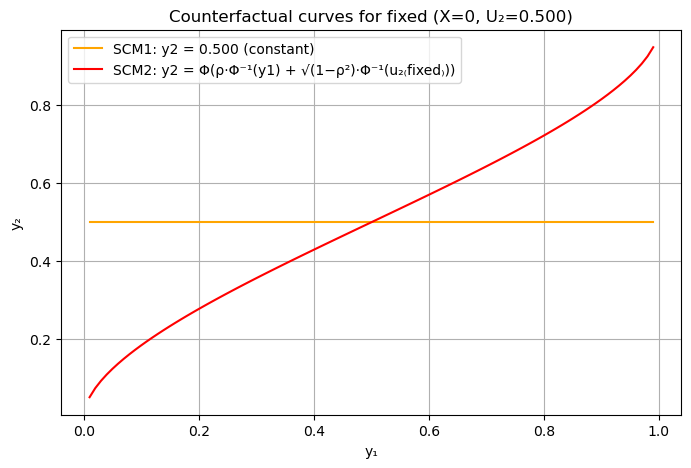

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal

# Set random seed for reproducibility
np.random.seed(42)

# Simulation parameters
n_samples = 5000
rho = 0.7

def simulate_scm1(n, rho):
    """
    SCM 1: Correlated noise via Gaussian copula
      Y1 = X + U1
      Y2 = X + U2
    where (U1, U2) ~ Gaussian copula with correlation rho
    """
    # 1. Sample X ~ Bernoulli(0.5)
    X = np.random.binomial(1, 0.5, size=n)
    
    # 2. Generate correlated normals (Z1, Z2) with Corr(Z1,Z2)=rho
    mean = [0, 0]
    cov = [[1, rho], [rho, 1]]
    z = multivariate_normal.rvs(mean=mean, cov=cov, size=n)
    
    # 3. Convert to uniforms: U1 = Φ(Z1), U2 = Φ(Z2)
    U1 = norm.cdf(z[:, 0])
    U2 = norm.cdf(z[:, 1])
    
    # 4. Structural equations
    Y1 = X + U1
    Y2 = X + U2
    
    return X, U1, U2, Y1, Y2

def simulate_scm2(n, rho):
    """
    SCM 2: Independent uniforms, apply conditional quantile for Y2
      Y1 = X + U1
      Y2 = X + Φ(rho*Φ^{-1}(U1) + sqrt(1 - rho^2)*Φ^{-1}(U2))
    """
    # 1. Sample X ~ Bernoulli(0.5)
    X = np.random.binomial(1, 0.5, size=n)
    
    # 2. Draw independent uniforms
    U1 = np.random.uniform(0, 1, size=n)
    U2 = np.random.uniform(0, 1, size=n)
    
    # 3. Y1 = X + U1
    Y1 = X + U1
    
    # 4. Compute latent normals for conditional quantile
    z1 = norm.ppf(U1)
    z2 = norm.ppf(U2)
    
    # 5. Compose conditional quantile: z2_cond = rho*z1 + sqrt(1 - rho^2)*z2
    z2_cond = rho * z1 + np.sqrt(1 - rho**2) * z2
    U2_cond = norm.cdf(z2_cond)
    
    # 6. Y2 = X + U2_cond
    Y2 = X + U2_cond
    
    return X, U1, U2, Y1, Y2

# Simulate data from SCM1
X, U1, U2, Y1, Y2 = simulate_scm1(n_samples, rho)

# Filter for X = 0 to pick a valid (U2, X) pair
mask = (X == 0)
# Choose the first such sample
u2_fixed = 0.5#U2[mask][0]

# Create a grid of y1 values in (0, 1) for plotting y2(y1)
y1_grid = np.linspace(0.01, 0.99, 100)

# Compute y2(y1) under SCM1: y2 is constant = U2_fixed
y2_scm1 = np.full_like(y1_grid, u2_fixed)

# Compute y2(y1) under SCM2:
# y2 = Φ(rho * Φ^{-1}(y1) + sqrt(1 - rho^2) * Φ^{-1}(u2_fixed))
z2_fixed = norm.ppf(u2_fixed)
y2_scm2 = norm.cdf(rho * norm.ppf(y1_grid) + np.sqrt(1 - rho**2) * z2_fixed)

# Plot the two curves
plt.figure(figsize=(8, 5))
plt.plot(y1_grid, y2_scm1, label=f'SCM1: y2 = {u2_fixed:.3f} (constant)', color='orange')
plt.plot(y1_grid, y2_scm2, label='SCM2: y2 = Φ(ρ·Φ⁻¹(y1) + √(1−ρ²)·Φ⁻¹(u₂₍fixed₎))', color='red')
plt.xlabel('y₁')
plt.ylabel('y₂')
plt.title(f'Counterfactual curves for fixed (X=0, U₂={u2_fixed:.3f})')
plt.legend()
plt.grid(True)
plt.show()